# Cordic——机械臂运动学正解
> 该实验改编自Xilinx的[FPGA并行编程 第三章 Cordic](https://xupsh.gitbook.io/pp4fpgas-cn/zheng-wen/03-cordic)，使用Xilinx Vitis HLS生成的FIR IP来进行六自由度机械臂的运动学正解。

因为对python不甚了解，只能做一些简单的数据和绘图，所以内容上会比较单薄:(


首先设置一组角度数据：
- 第七轴对位置没有贡献所以略去
- 第一轴所在的空间位置设为(0,0,0)
- 输入角度的范围为(-180,180)

<div style='max-width: 1005px;'>
<div style='width:40%; float:left; text-align:center;'>
    <img src="./arm_exp.png"/>

In [1]:
import numpy as np
theta_in = np.array([30,40,20,60,50,40])
theta_in[0:6]

array([30, 40, 20, 60, 50, 40])

由于变量定义的定点数小数部分为15位，所以全部数据左移15位。

In [2]:
import numpy as np
theta = np.array([theta_in[0]<<15,theta_in[1]<<15,
                  theta_in[2]<<15,theta_in[3]<<15,
                  theta_in[4]<<15,theta_in[5]<<15])
theta[0:6]

array([ 983040, 1310720,  655360, 1966080, 1638400, 1310720])

### 加载Overlay

Overlay模块封装了ARM CPU与FPGA的PL部分进行交互的接口。

- 我们可以通过简单的`Overlay()`方法将刚才生成的硬件设计加载到PL上
- 通过`overlay.cordic_wrap_0`语句，我们可以通过访问的Python对象的形式来与IP交互

In [3]:
from pynq import Overlay
overlay = Overlay("./cordic.bit")
cordic = overlay.cordic_wrap_0

### 分配内存供IP使用
`pynq.allocate`函数用于为PL中的IP分配可以使用的内存空间。
- 在PL中的IP访问DRAM之前，必须为其保留一些内存供IP使用，分配大小与地址
- 我们分别为输入、sin输出和cos输出三个部分分配内存，数据类型为int32_t
- `pynq.allocate`会分配物理上的连续内存，并返回一个`pynq.Buffer`表示已经分配缓冲区的对象

In [4]:
from pynq import allocate
sample_len = len(theta)
input_buffer = allocate(shape=(sample_len,), dtype='i4')
output_s_buffer = allocate(shape=(sample_len,), dtype='i4')
output_c_buffer = allocate(shape=(sample_len,), dtype='i4')

将预设的角度值复制到我们刚分配的内存中。

In [5]:
np.copyto(input_buffer, np.array(theta))

我们可以看到，缓冲区本质也是numpy数组，但是提供了一些物理地址属性。

In [6]:
input_buffer[0:6]

PynqBuffer([ 983040, 1310720,  655360, 1966080, 1638400, 1310720])

In [7]:
input_buffer.physical_address

377786368

### 配置IP

我们可以直接使用IP的`write`方法，将刚分配的内存空间的地址写入到IP对应位置上

对于数据长度，我们可以直接在对应寄存器写入值。

In [8]:
cordic.s_axi_control.write(0x10,input_buffer.physical_address)
cordic.s_axi_control.write(0x1c,output_s_buffer.physical_address)
cordic.s_axi_control.write(0x28,output_c_buffer.physical_address)
cordic.s_axi_CTRL.write(0x10, sample_len)

### 启动IP

控制信号位于0x00地址，我们可以对其进行写入与读取来控制IP启动、监听是否完成。

In [9]:
import time

cordic.s_axi_CTRL.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = cordic.s_axi_CTRL.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.0008859634399414062s


结果已经被写入到了`output_buffer`中，我们可以进行查看

同样的输出的数据要右移15位处理。

In [10]:
output_s=np.array([(output_s_buffer[0]/(float)(1<<15)),(output_s_buffer[1]/(float)(1<<15)),
                   (output_s_buffer[2]/(float)(1<<15)),(output_s_buffer[3]/(float)(1<<15)),
                   (output_s_buffer[4]/(float)(1<<15)),(output_s_buffer[5]/(float)(1<<15))])
output_s

array([0.50006104, 0.64285278, 0.34207153, 0.8661499 , 0.7661438 ,
       0.64285278])

In [11]:
output_c=np.array([(output_c_buffer[0]/(float)(1<<15)),(output_c_buffer[1]/(float)(1<<15)),
                   (output_c_buffer[2]/(float)(1<<15)),(output_c_buffer[3]/(float)(1<<15)),
                   (output_c_buffer[4]/(float)(1<<15)),(output_c_buffer[5]/(float)(1<<15))])
output_c

array([0.8661499 , 0.7661438 , 0.93966675, 0.50006104, 0.64285278,
       0.7661438 ])

### 可视化结果

使用绘图组件，我们对硬件函数的结果进行可视化

- 为了简化计算，预设各臂长为1
- 利用了旋转矩阵的方案
- 可以看到，各关节的位置都可解出

两个旋转矩阵：

In [19]:
rot_1=np.array([[output_c[0], -output_s[0]*output_c[1], output_s[0]*output_s[1]],
                [output_s[0], output_c[0]*output_c[1], -output_c[0]*output_s[1]],
                [0, output_s[1], output_c[1]]])

In [20]:
rot_2=np.array([[output_c[2], -output_s[2]*output_c[3], output_s[2]*output_s[3]],
                [output_s[2], output_c[2]*output_c[3], -output_c[2]*output_s[3]],
                [0, output_s[3], output_c[3]]])

五个位置向量：

In [21]:
position_0=np.array([0,0,0])

In [22]:
position_1=np.array([0,0,1])

In [23]:
relative_2=np.array([output_c[0]*output_s[1],
                     output_s[0]*output_s[1],
                     output_c[1]])
position_2=position_1+relative_2
position_2

array([0.55680688, 0.32146563, 1.7661438 ])

In [24]:
relative_3=np.array([output_c[2]*output_s[3],
                     output_s[2]*output_s[3],
                     output_c[3]])

position_3=np.dot(relative_3,rot_1)
position_3=position_2+position_3
position_3

array([ 1.40992028, -0.47679096,  2.60751435])

In [25]:
relative_4=np.array([output_c[4]*output_s[5],
                     output_s[4]*output_s[5],
                     output_c[5]])
position_4=np.dot(relative_4,rot_2)
position_4=np.dot(position_4,rot_1)
position_4=position_3+position_4
position_4

array([ 1.32455432, -0.53183395,  2.59787295])

得到五个关节的位置向量后就可以在空间中绘制姿态：

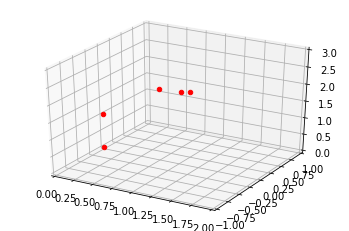

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, 3)  # X轴，横向向右方向
ax.set_ylim(-1, 1) # Y轴,左向与X,Z轴互为垂直
ax.set_zlim(0, 3)  # 竖向为Z轴
ax.scatter(position_0[0], position_0[1], position_0[2], s=20, c='r', depthshade=False)
ax.scatter(position_1[0], position_1[1], position_1[2], s=20, c='r', depthshade=False)
ax.scatter(position_2[0], position_2[1], position_2[2], s=20, c='r', depthshade=False)
ax.scatter(position_3[0], position_3[1], position_3[2], s=20, c='r', depthshade=False)
ax.scatter(position_4[0], position_4[1], position_4[2], s=20, c='r', depthshade=False)

因为本人能力有限，所以notebook部分只是现学现做了一些简单的内容，可视化的部分也不够理想。

另外因为时间关系，功能上也只是简单制作了Cordic的部分，提出一个完善的思路：在计算位置信息的步骤中包含矩阵的乘法，可以将这一部分直接加入IP中，IP直接输出计算完成的位置向量。